# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>


## PyTorch и полносвязные нейронные сети

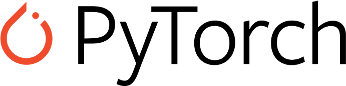

Обучение нейронной сети заключается в минимизации некоторой функции потерь, зависящей от значений активации нейронов. Так как мы знаем весь процесс построения этой функции, то для минимизации нам достоточно посчитать градиент от всех параметров функции (нейронов) и затем двигаться по нему, обновляя значения параметров. Однако современные нейронные сети могут содержать в себе миллиарды параметров (например, GPT-3 содержит 175 миллиардов, а гугловская PaLM 540 миллиардов!), что делает вычисление градиента вручную невозможным. К счастью, люди придумали как автоматизировать этот процесс с помощью вычислительного графа, и написали библиотеки (Keras, TensorFlow, PyTorch), которые занимаются этим за нас :)

PyTorch - это один из фреймфорков для задач глубокого обучения, то есть библиотека, позволяющая:
* Производить быстрые матричные вычисления с использованием видеопамяти
* Строить вычислителный граф и дифференцировать его (то есть сможем поучать градиент функции потерь)

In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict
from collections import OrderedDict

import matplotlib.pyplot as plt
# import seaborn as sns
from IPython.display import clear_output
# sns.set(palette='Set2', font_scale=1.5)

import torch
from torch import nn
import torch.nn.functional as F

print(torch.__version__)

2.0.1+cu118


# Torch Tensor

Основным объектом, с которым оперирует PyTorch, является `torch.tensor`. Он представляет собой многомерную матрицу с элементами одного типа данных. Работа с тензорами в PyTorch похолжа на работу с массивами в `numpy`. Посмотрим на некоторые методы `torch.tensor`

### Инициализация

Тензор можно создать из списка, кортежа, массива numpy или просто числа

In [2]:
print(torch.tensor([1, 2, 3]), 'тензор из списка')
print(torch.tensor((1, 2, 3)), 'тензор из кортежа')
print(torch.tensor(np.array([1, 2, 3])), 'тензор из массива numpy')
print(torch.tensor((1)), 'тензор из числа')

tensor([1, 2, 3]) тензор из списка
tensor([1, 2, 3]) тензор из кортежа
tensor([1, 2, 3]) тензор из массива numpy
tensor(1) тензор из числа


Так же, как и в `numpy`, тензор может быть создан произвольного размера. Узнать размер тензора можно вызвав метод `size()` или посмотрев атрибут `shape`.

In [3]:
t = torch.tensor([[1, 2, 3], [2, 3, 4]])

print(t)
print(t.size(), 'метод `size()`')
print(t.shape, 'атрибут shape')

tensor([[1, 2, 3],
        [2, 3, 4]])
torch.Size([2, 3]) метод `size()`
torch.Size([2, 3]) атрибут shape


Можно конкретизировать тип данных с помощью аргумент `dtype`.

In [4]:
t = torch.tensor([[1, 2, 3], [2, 3, 4]], dtype=torch.float64)
print(t)

tensor([[1., 2., 3.],
        [2., 3., 4.]], dtype=torch.float64)


Аналогично `numpy` есть методы создания матриц, заполненных нулями и единицами: `zeros()`, `ones()`.

### Математические операции

Над тензорами можно производить математические операции, так же как и в `numpy`. Например складывать с числом и умнажать на число

In [5]:
a = torch.ones((2, 3))

print(a, 'изначальный тензор A\n')

print(a + 1, 'A + 1\n')

print(a * 3, 'A * 3\n')

tensor([[1., 1., 1.],
        [1., 1., 1.]]) изначальный тензор A

tensor([[2., 2., 2.],
        [2., 2., 2.]]) A + 1

tensor([[3., 3., 3.],
        [3., 3., 3.]]) A * 3



Складывать и умножать два тезора (поэлементно)

In [6]:
a = torch.ones((2, 3))
b = torch.full((2, 3), 8)

print(f'A = {a}\n\nB = {b}\n\nA + B = {a + b}\n\nA * B = {a * b}')

A = tensor([[1., 1., 1.],
        [1., 1., 1.]])

B = tensor([[8, 8, 8],
        [8, 8, 8]])

A + B = tensor([[9., 9., 9.],
        [9., 9., 9.]])

A * B = tensor([[8., 8., 8.],
        [8., 8., 8.]])


Умножать тензоры матрично

In [7]:
a = torch.ones((2, 3))
b = torch.full((3, 2), 8.)


print(f'A = {a}\n\nB = {b}\n\nA @ B = {a @ b}')

A = tensor([[1., 1., 1.],
        [1., 1., 1.]])

B = tensor([[8., 8.],
        [8., 8.],
        [8., 8.]])

A @ B = tensor([[24., 24.],
        [24., 24.]])


Применять агрегирующие функции

In [8]:
a = torch.ones((4, 3))


print(a, 'Тензор A\n')
print(f'Усреденение по столбцам A  = {a.mean(dim=0)}\n')
print(f'Сумма по строчкам A  = {a.sum(dim=1)}\n')
print(f'Кумулятивная сумма по столбцам A:\n{a.cumsum(dim=0)}')

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]) Тензор A

Усреденение по столбцам A  = tensor([1., 1., 1.])

Сумма по строчкам A  = tensor([3., 3., 3., 3.])

Кумулятивная сумма по столбцам A:
tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.]])


### Переход от `torch.tensor` к `numpy.ndarray`

Если вам требуется перевести тензор в массив numpy, то сделать это можно вызовом метода `numpy()`

In [9]:
t = torch.ones((2, 3))

print(type(t), 't - тензор\n')
print(type(t.numpy()), 't стал массивом numpy')

<class 'torch.Tensor'> t - тензор

<class 'numpy.ndarray'> t стал массивом numpy


**ЗАДАЧА 1**

Пользуясь функциями `torch.tensor` создайте **один** тензор, и посчитайте с его помощью сумму чисел от 1 до 100. Затем посчитайте суммы чисел в каждом десятке (от 1 до 10, от 11 до 20 и так далее)

In [33]:
t = torch.arange(1,101,1)
print(t.sum())
t.reshape(10,10).sum(dim = 1)

tensor(5050)


tensor([ 55, 155, 255, 355, 455, 555, 655, 755, 855, 955])

Все же некоторые названия методов отличаются от `numpy`-евских. Полной совместимости с `numpy` пока нет, но от версии к версии разрыв сокращается, и придется снова запоминать новые названия для некоторых методов.

Например, PyTorch имеет другое написание стандартных типов
 * `x.astype('int64') -> x.type(torch.LongTensor)`


Для более подробного ознакомления можно посмотреть на <a href="https://github.com/torch/torch7/wiki/Torch-for-Numpy-users" target="_blank">табличку</a> перевода методов из `numpy` в `torch`, а также заглянуть в <a href="http://pytorch.org/docs/master/" target="_blank">документацию</a>. Также при возникновении проблем часто помогает зайти на <a href="https://discuss.pytorch.org/" target="_blank">pytorch forumns</a>. Можете также глянуть эту <a href="https://qudata.com/ml/ru/NN_Base_Torch.html" target="_blank">шпаргалку</a> по тензорам

**ЗАДАЧА 2**

Нарисуйте по сетке данную кривую на графике, используя `torch`:

$$x(t) = 2 \cos t + \sin 2t \cos 60t,$$

$$y(t) = \sin 2t + \sin 60t.$$

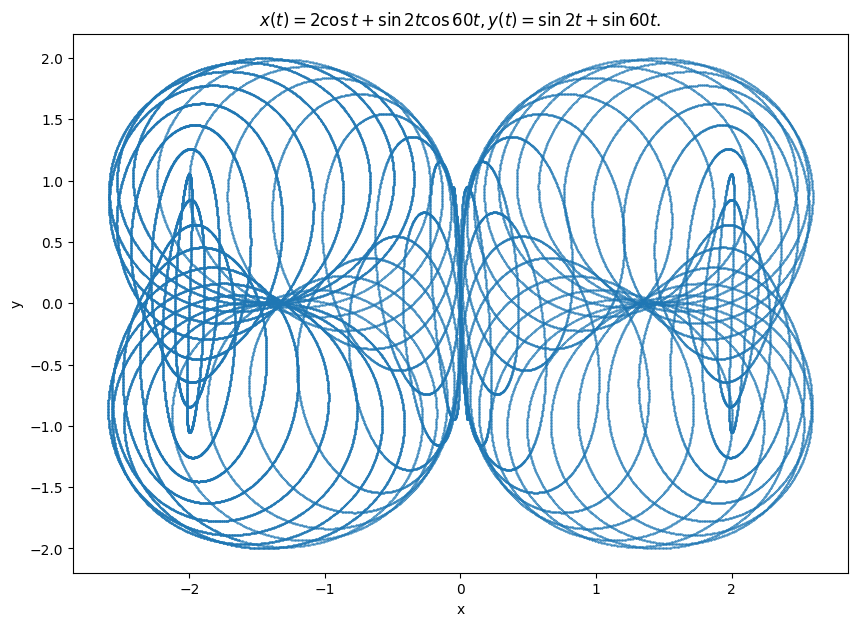

In [74]:
t = torch.arange(-4, 4, 0.0001)
x = 2*torch.cos(t)+torch.sin(2*t)*torch.cos(60*t)
y = torch.sin(2*t)+torch.sin(60*t)

plt.figure(figsize=(10, 7))
plt.scatter(x, y, s = 0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('$x(t) = 2 \cos t + \sin 2t \cos 60t, y(t) = \sin 2t + \sin 60t.$');

Заметим, что библиотека `matplotlib` справляется с отображением `pytorch`-тензоров, и дополнительных преобразований делать не нужно.



## Вычисление на видеокарте

Если, тензоры в PyTorch и массивы в NumPy так похожи, то зачем нам вообще нужен PyTorch? Для этого надо вспомнить, что нейросети бывают огромных размеров, а проводить операции над большими матрицами вычислетельно дорого. Давайте перемножим две матрицы размером 10000 на 10000 (слои трансформеры в GPT-3 содеражт матрицы ещё большего размера):

In [53]:
import time

n = 10000

In [54]:
a = np.ones((n, n))

In [55]:
start = time.time()

np.dot(a, a)

end = time.time() - start

print(end)

55.479450702667236


Вроде бы терпимо. Теперь представьте, что данную операцию надо совершить десятки тысяч раз, и над несколькими матрицами. Уже ставится грустно. Однако, матричные вычисления хорошо распараллеливаются и тут на сцену выходит PyTorch. В нём реализовано распараллеливание вычислений с помощью видеокарт, что позволяет в разы ускорить работу с матрицами в разы

Стандартом является использование видеокарт NVidia и языка CUDA (хотя есть поддержка и других производителей). Для начала вычислений на видеокарте надо перенести на неё тензор, вызвав метод `cuda`:

In [56]:
t = torch.ones((n, n))

device = 'cuda'
t = t.to(device) #переносим тензор на видеокарту

In [57]:
t.device #проверим, что перенеслось

device(type='cuda', index=0)

Теперь можно производить вычисления с использованием видеокарты

In [58]:
start = time.time()

torch.mul(t, t)

end = time.time() - start

print(end)

0.00033974647521972656


Как видите, ускорение в несколько тысяч раз!

## Дифференцирование



Обучение нейронной сети опирается на алгоритм обратного распространения ошибки, для этого необходимо уметь строить граф вычислений и дифференцировать его. Как вы уже догодались, PyTorch с эти успешно справляется. Посмотрим как это происходит

Установим библиеотек для визуализации графа

In [59]:
!pip install torchviz
!pip install graphviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=d37c08ab086e1fa60ba3a8a070e0f334296ade564b99b9af794cd94c06ce4c0b
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [60]:
from graphviz import Digraph
import torch
from torch.autograd import Variable

from torchviz import make_dot

Для того, чтобы добавить тензор к вычислительному графу необходимо при его создании установить параметр `requires_grad=True`. Обратите внимание, что только тензоры вещественных числе  можно привязать к графу

Построим вычислительный граф для следующей функции

$$f(x, y)=x^2 * y + 10x^{\sin(y)}$$



In [75]:
x = torch.tensor(1, requires_grad=True, dtype=torch.float)
y = torch.tensor(1, requires_grad=True, dtype=torch.float)

In [76]:
f = x ** 2 * y + 10 * x ** torch.sin(y)

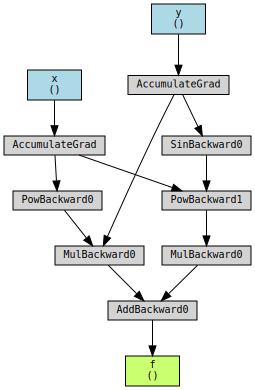

In [77]:
make_dot(f, params={'x': x, 'y': y, 'f': f})

Для того, чтобы посчитать градиент функции по всем параметрам, надо всего лишь вызвать метод `backward`

In [64]:
f.backward()

Получившиеся градиенты являются атрибутами параметров функции. Чтобы посмотреть их надо посмотреть атрибут `grad`

In [65]:
y.grad

tensor(1.)

In [66]:
x.grad

tensor(10.4147)

PyTorch устроен так, что градиенты накапливаются

In [67]:
f = x ** 2 * y + 10 * x ** torch.sin(y)
f.backward()

In [68]:
y.grad

tensor(2.)

In [69]:
x.grad

tensor(20.8294)

Поэтому прежде чем повторять процедуру дифференцирования необходиомо занулить градиенты

In [70]:
x.grad.zero_()
x.grad

tensor(0.)

In [71]:
y.grad.zero_()
y.grad

tensor(0.)

Чтобы отсоеденить тензор от вычислительного графа и перестать накапливать градиенты воспользуйтесь методом `detach()`

In [72]:
x.detach()

tensor(1.)

Чтобы создать копию тензора можно воспользоваться методом `clone()`, при этом склонированный тензор будет присоединён к графу.

In [73]:
a = y.clone()
a

tensor(1., grad_fn=<CloneBackward0>)

**ЗАДАНИЕ 3**

Посчитайте производную функции

$$f(x, y, z)=\frac{x^2 + y^2}{\exp z}$$

по переменной $x$ в точке (1, 1, 0)

In [102]:
x = torch.ones(1, requires_grad=True, dtype=torch.float)
y = torch.ones(1, requires_grad=True, dtype=torch.float)
z = torch.zeros(1, requires_grad=True, dtype=torch.float)

f = (x**2 + y**2)/torch.exp(z)

In [103]:
f.backward()

In [104]:
x.grad

tensor([2.])

## Простой пример обучения нейронной сети

Теперь, можно приступить к самому главному назначению PyTorch и обучить нейросеть


### Цикл обучения модели

Посмотрим на общий процесс обучения. Пусть задана нейронная сеть $f(x)$, параметризуемая обучаемыми параметрами $\theta$. Для входных данных $x$ модель возращает $\widehat{y}=f(x)$. Для обучения модели необходимо задать оптимизируемую функцию (функцию ошибки, лосс) $L(y, \widehat{y})$, которую следует минимизовать.


Процесс обучения задается следующим образом.
 * **Прямой проход / Forward pass:** <br>
     Считаем $\widehat{y}=f(x)$ для входных данных $x$. <br>
 * **Вычисление оптимизируемой функции:**<br>
     Вычисляем оптимизируемую функцию $L(y, \widehat{y})$. <br>
 * **Обратный проход / Backward pass:** <br>
     Считаем градиенты по всем обучаемым параметрам $\frac{\partial L}{\partial \theta}$. <br>
 * **Шаг оптимизации:** <br>
     Делаем шаг градиентного спуска, обновляя все обучаемые параметры. <br>
    

### Линейная регрессия

В лекциях показано, что линейную регрессию можно представить как частный случай нейрона с тождественной функцией активации.

Сделаем одномерную линейную регрессию на датасете <a href="http://lib.stat.cmu.edu/datasets/boston" target="_blank">boston</a>. Этот датасет представляет собой набор данных конца 70-х годов прошлого века для предсказания цены недвижимости в Бостоне.

Скачиваем данные.

In [105]:
def load_boston():
    # ссылка для скачивания данных
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    # собираем таблицу данных
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    # выделяем признаки и таргет
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    return data, target

In [106]:
data, target = load_boston()

Будем рассматривать зависимость таргета, т.е. медианной стоимости домов в тысячах долларов, от последнего признака, т.е. процента населения людей с низким уровнем дохода.

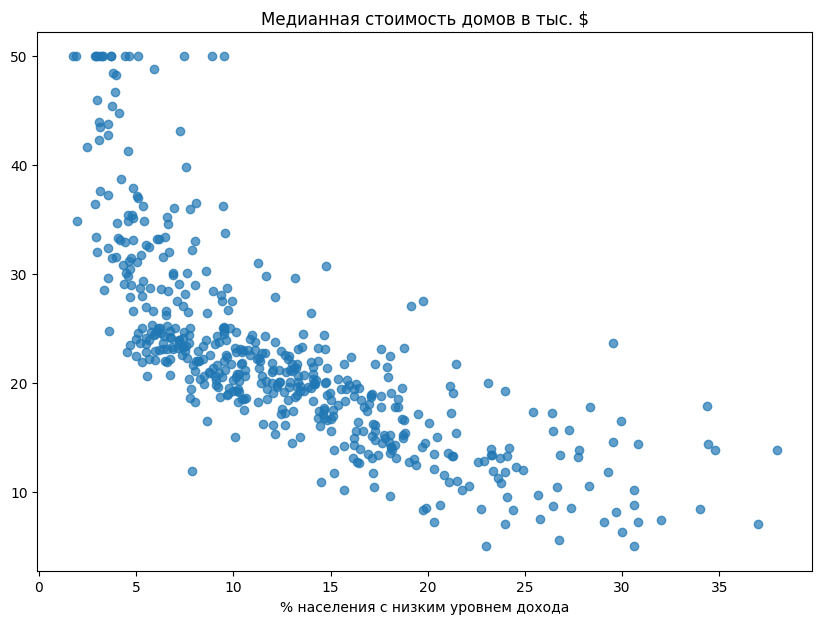

In [107]:
plt.figure(figsize=(10, 7))
plt.scatter(data[:, -1], target, alpha=0.7)
plt.xlabel('% населения с низким уровнем дохода')
plt.title('Медианная стоимость домов в тыс. $');

В данном случае предсказание модели задается следующим образом: $$\widehat{y}(x) = wx + b,$$
где $w, b \in \mathbb{R}$ &mdash; обучаемые параметры модели. Это обычная линейная модель, и с ней мы уже работали <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html" target="_blank">ранее</a>.

Объявляем обучаемые параметры. Также задаем признак $X$ и таргет $Y$ в виде `torch`-тензоров.

In [108]:
# создаем два тензора размера 1 с заполнением нулями,
# для которых будут вычисляться градиенты
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Данные оборачиваем в тензоры, по которым не требуем вычисления градиента
x = torch.FloatTensor(data[:, -1] / 10)
y = torch.FloatTensor(target)

# по-другому:
# x = torch.tensor(boston.data[:, -1] / 10, dtype=torch.float32)
# y = torch.tensor(boston.target, dtype=torch.float32)

Зададим оптимизируемую функцию / функцию ошибки / лосс &mdash; <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html#3.-Тестирование-и-оценка-качества" target="_blank">MSE</a>:

$$
\mathrm{MSE}(\widehat{y}, y) = \frac{1}{n} \sum_{i=1}^n \left(\widehat{y}_i - y_i\right)^2.
$$


In [110]:
def optim_func(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

После того, как мы посчитаем результат применения этой функции к нашим данным, нам необходимо посчитать градиенты по всем обучаемым параметрам, чтобы затем сделать шаг градиентного спуска. В этом нам поможет функция `backward`. Вызвав `backward` для результата подсчета функции ошибки `loss`, мы сделаем обратный проход по всему графу вычислений и посчитаем градиенты лосса по всем обучаемым параметрам. Подробнее о том, как это работает будет рассказано на 3 курсе.

In [111]:
# Прямой проход
y_pred = w * x + b

# Вычисление лосса
loss = optim_func(y_pred, y)

# Вычисление градиентов
# с помощью обратного прохода по сети
# и сохранение их в памяти сети
loss.backward()

Здесь `loss` &mdash; значение функции MSE, вычисленное на этой итерации.

In [112]:
loss

tensor(592.1469, grad_fn=<MeanBackward0>)

К градиентам для обучаемых параметров, которые требуют градиента (`requires_grad=True`), теперь можно обратиться следующим образом:

In [113]:
print("dL/dw =", w.grad)
print("dL/b =", b.grad)

dL/dw = tensor([-47.3514])
dL/b = tensor([-45.0656])


Если мы посчитаем градиент $M$ раз, то есть $M$ раз вызовем `loss.backward()`, то градиент будет накапливаться (суммироваться) в параметрах, требующих градиента. Иногда это бывает удобно.

Убедимся на примере, что именно так все и работает.

In [114]:
y_pred = w * x + b
loss =  optim_func(y_pred, y)
loss.backward()

print("dL/dw =", w.grad)
print("dL/b =", b.grad)

dL/dw = tensor([-94.7029])
dL/b = tensor([-90.1312])


Видим, что значения градиентов стали в 2 раза больше, за счет того, что мы сложили одни и те же градиенты 2 раза.

Если же мы не хотим, чтобы градиенты суммировались, то нужно **занулять
градиенты** между итерациями после того как сделали шаг градиентного спуска.
Это можно сделать с помощью функции `zero_` для градиентов.

In [115]:
w.grad.zero_()
b.grad.zero_()
w.grad, b.grad

(tensor([0.]), tensor([0.]))

Напишем функцию визуализации процесса обучения.

In [116]:
def show_progress(x, y, y_pred, loss):
    '''
    Визуализация процесса обучения.

    x, y -- объекты и таргеты обучающей выборки;
    y_pred -- предсказания модели;
    loss -- текущее значение ошибки модели.
    '''

    # Избавимся от градиентов перед отрисовкой графика
    y_pred = y_pred.detach()

    # Превратим тензор размерности 0 в число, для красивого отображения
    loss = loss.item()

    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.75)
    plt.scatter(x, y_pred, color='orange', linewidth=5)
    plt.xlabel('% населения с низким уровнем дохода')
    plt.title('Медианная стоимость домов в тыс. $')
    plt.show()

    print(f"MSE = {loss:.3f}")

**ЗАДАЧА 4**

Построем нейронную сеть из двух слоев:

$$\widehat{y}(x) = w_2u(x) + b_2,$$

$$u(x) = \sigma(w_1x + b_1),$$

$$\sigma(x) = \text{ReLU}(x) = \begin{equation*}\begin{cases}x, \; x \ge 0, \\ 0, \; \text{иначе,} \end{cases} \end{equation*}$$

$w_1, b_1 \in \mathbb{R}$ &mdash; обучаемые параметры первого слоя, $w_2, b_2 \in \mathbb{R}$ &mdash; обучаемые параметры второго слоя, $\sigma(x)$ &mdash; функция активации, в данном случае мы выбрали `ReLU`. Можно заметить, что это функция не удовлетворяет условиям теоремы Цыбенко, тем не менее на практике она часто применяется для нейронных сетей.

In [119]:
x = torch.FloatTensor(data[:, -1] / 10)
y = torch.FloatTensor(target)

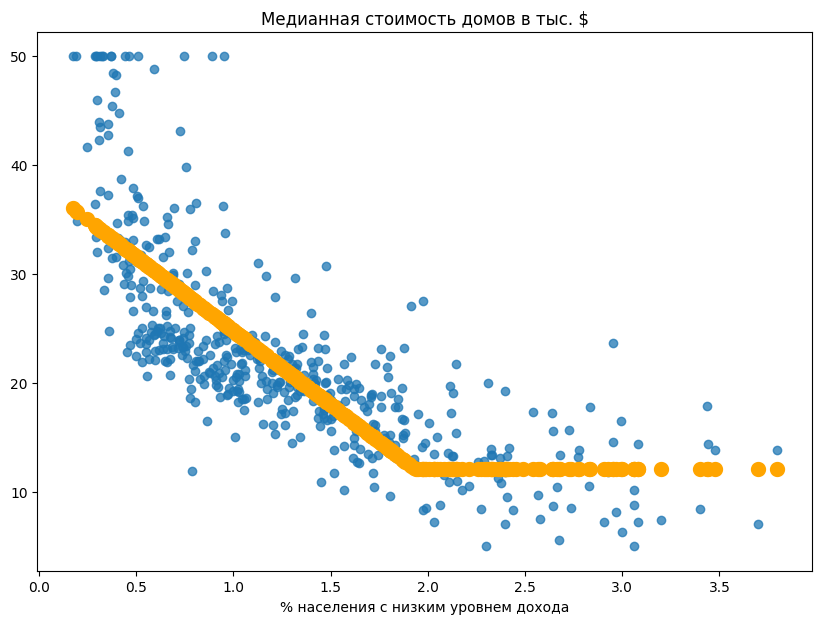

MSE = 32.994
Готово!


In [126]:
# Инициализация параметров
w0 = torch.ones(1, requires_grad=True)
b0 = torch.ones(1, requires_grad=True)
w1 = torch.ones(1, requires_grad=True)
b1 = torch.ones(1, requires_grad=True)

# Функция активации
def act_func(x):
    return x * (x >= 0)

# Количество итераций
num_iter = 1000

# Скорость обучения для параметров
lr_w = 0.01
lr_b = 0.05

for i in range(num_iter):

    # Forward pass: предсказание модели
    y_pred =  w1*act_func(w0*x+b0)+b1

    # Вычисление оптимизируемой функции (MSE)
    loss = optim_func(y_pred, y)

    # Bakcward pass: вычисление градиентов
    loss.backward()

    # Оптимизация: обновление параметров
    w0.data -= lr_w * w0.grad.data
    b0.data -= lr_b * b0.grad.data
    w1.data -= lr_w * w1.grad.data
    b1.data -= lr_b * b1.grad.data

    # Зануление градиентов
    w0.grad.zero_()
    b0.grad.zero_()
    w1.grad.zero_()
    b1.grad.zero_()

    # График + вывод MSE через каждые 5 итераций
    if (i + 1) % 5 == 0:
        show_progress(x, y, y_pred, loss)

        if loss.item() < 33:
            print("Готово!")
            break